In [204]:
import numpy as np
import torch
import torchvision as tv
from torchvision import transforms, datasets
from model import VSE, order_sim
from data import get_test_loader

from vocab import Vocabulary

import os
import pickle
import time

import PIL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.neighbors import NearestNeighbors

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [206]:
# prepare VSE model
datapath = "data/"
modelpath = "runs/coco_vse++_resnet_restval_finetune/model_best.pth.tar"
checkpoint = torch.load(modelpath, map_location=lambda storage, loc: storage)
opt = checkpoint['opt']
opt.data_path = datapath

with open(os.path.join(opt.vocab_path,'%s_vocab.pkl' % opt.data_name),'rb') as f:
    vocab = pickle.load(f)
opt.vocab_size = len(vocab)

# construct model
model = VSE(opt)
# load model state
model.load_state_dict(checkpoint['model'])
# switch to evaluate mode
model.val_start()

model.img_enc = model.img_enc.cpu()
model.txt_enc = model.txt_enc.cpu()

=> using pre-trained model 'resnet152'


In [167]:
# build image transform
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
t_list = []
t_list = [transforms.Scale(256), transforms.CenterCrop(224)]
t_end = [transforms.ToTensor(), normalizer]
transform = transforms.Compose(t_list + t_end)

def transformimg(img):
    imgtensor = transform(img)
    imgtensor = imgtensor.unsqueeze(0)
    return imgtensor

In [207]:
class MyImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        img, _ = super(MyImageFolder, self).__getitem__(index)
        path = self.imgs[index][0].split("/")[-1]
        return (img, path)

batchnum = 60
val_set = MyImageFolder(root="data/coco/images/", transform=transform)
dataset_loader = torch.utils.data.DataLoader(val_set, batch_size=64, num_workers=4)
startt = time.time()
for i, data in enumerate(dataset_loader, 0):
    imgfeatures, path = data
    model.img_enc(torch.autograd.Variable(imgfeatures, volatile=True))
    
    if (i+1)%10 == 0:
        currt = time.time()
        print "{} batch(s) computed. time elapsed: {}".format(str(i+1), str(currt-startt))
    
    if i == batchnum:
        print 'done'
        break

10 batch(s) computed. time elapsed: 311.252374887


Process Process-45:
Process Process-47:
Process Process-48:
Process Process-46:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/csmac3/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/Users/csmac3/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/csmac3/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/csmac3/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/Users/csmac3/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/Users/csmac3/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/Users/csmac3/anaconda2/lib/python2.7/mu

KeyboardInterrupt: 

In [159]:
# load image vectors
imgbasepath = "data/coco/images/val2014/"
imgpathfile = open("val2014paths.pkl", "rb")
imgvfile = open("val2014imgvecs.pkl", "rb")
imgpaths = pickle.load(imgpathfile)
imgvectors = pickle.load(imgvfile)
imgnum = imgvectors.shape[0]

# build indexing for KNN
neighbors = NearestNeighbors(n_neighbors=9, algorithm='ball_tree').fit(imgvectors)

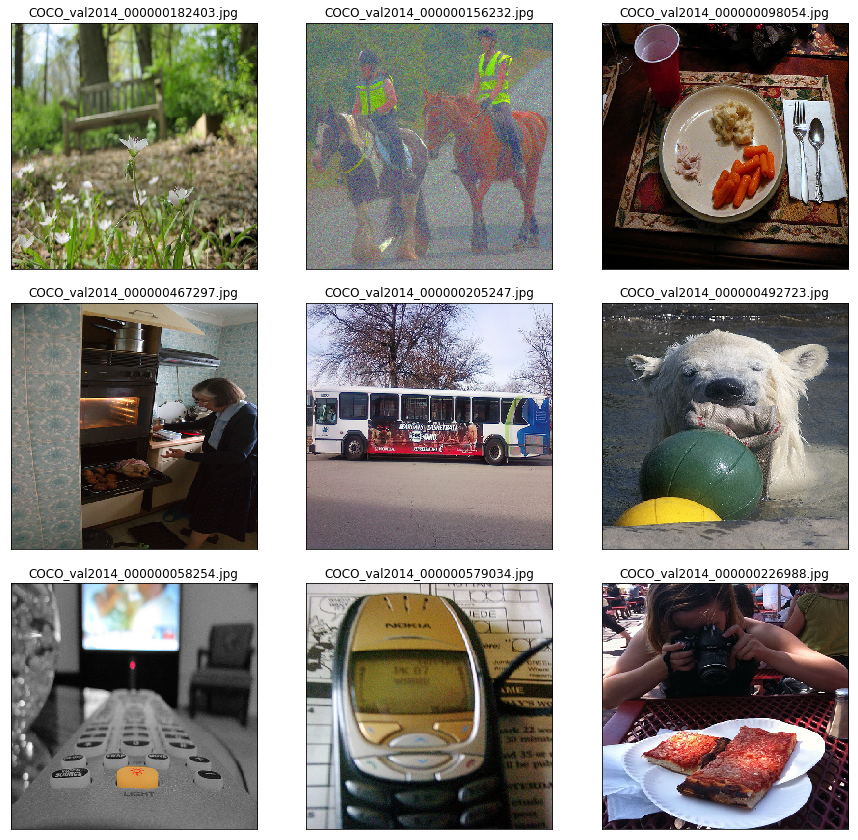

In [106]:
# randomly pick some image example from val set
pylab.rcParams['figure.figsize'] = (15, 15)
plt.subplots_adjust(hspace=.1)
randompick = np.random.choice(imgnum, 9, replace=False)
for i, rand in enumerate(randompick):
    randpath = imgbasepath+imgpaths[rand]
    randimg = Image.open(randpath)
    randimgrz = randimg.resize((256,256))
    sbplt = plt.subplot(3,3,1+i)
    sbplt.set_title(randpath.split("/")[-1])
    sbplt.get_xaxis().set_visible(False)
    sbplt.get_yaxis().set_visible(False)
    plt.imshow(randimgrz)

In [120]:
# prepare VSE model
datapath = "data/"
modelpath = "runs/coco_vse++_resnet_restval_finetune/model_best.pth.tar"
checkpoint = torch.load(modelpath, map_location=lambda storage, loc: storage)
opt = checkpoint['opt']
opt.data_path = datapath

with open(os.path.join(opt.vocab_path,'%s_vocab.pkl' % opt.data_name),'rb') as f:
    vocab = pickle.load(f)
opt.vocab_size = len(vocab)

# construct model
model = VSE(opt)
# load model state
model.load_state_dict(checkpoint['model'])
# switch to evaluate mode
model.val_start()

model.img_enc = model.img_enc.cpu()
model.txt_enc = model.txt_enc.cpu()

=> using pre-trained model 'resnet152'


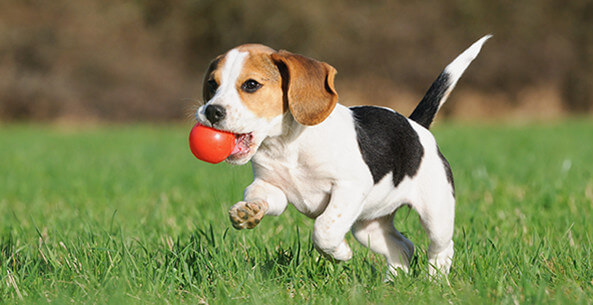

In [162]:
# queried image
querypath = "data/query.jpg"
queryimgpil = Image.open(querypath)
queryimg = transformimg(queryimgpil)
queryimgpil

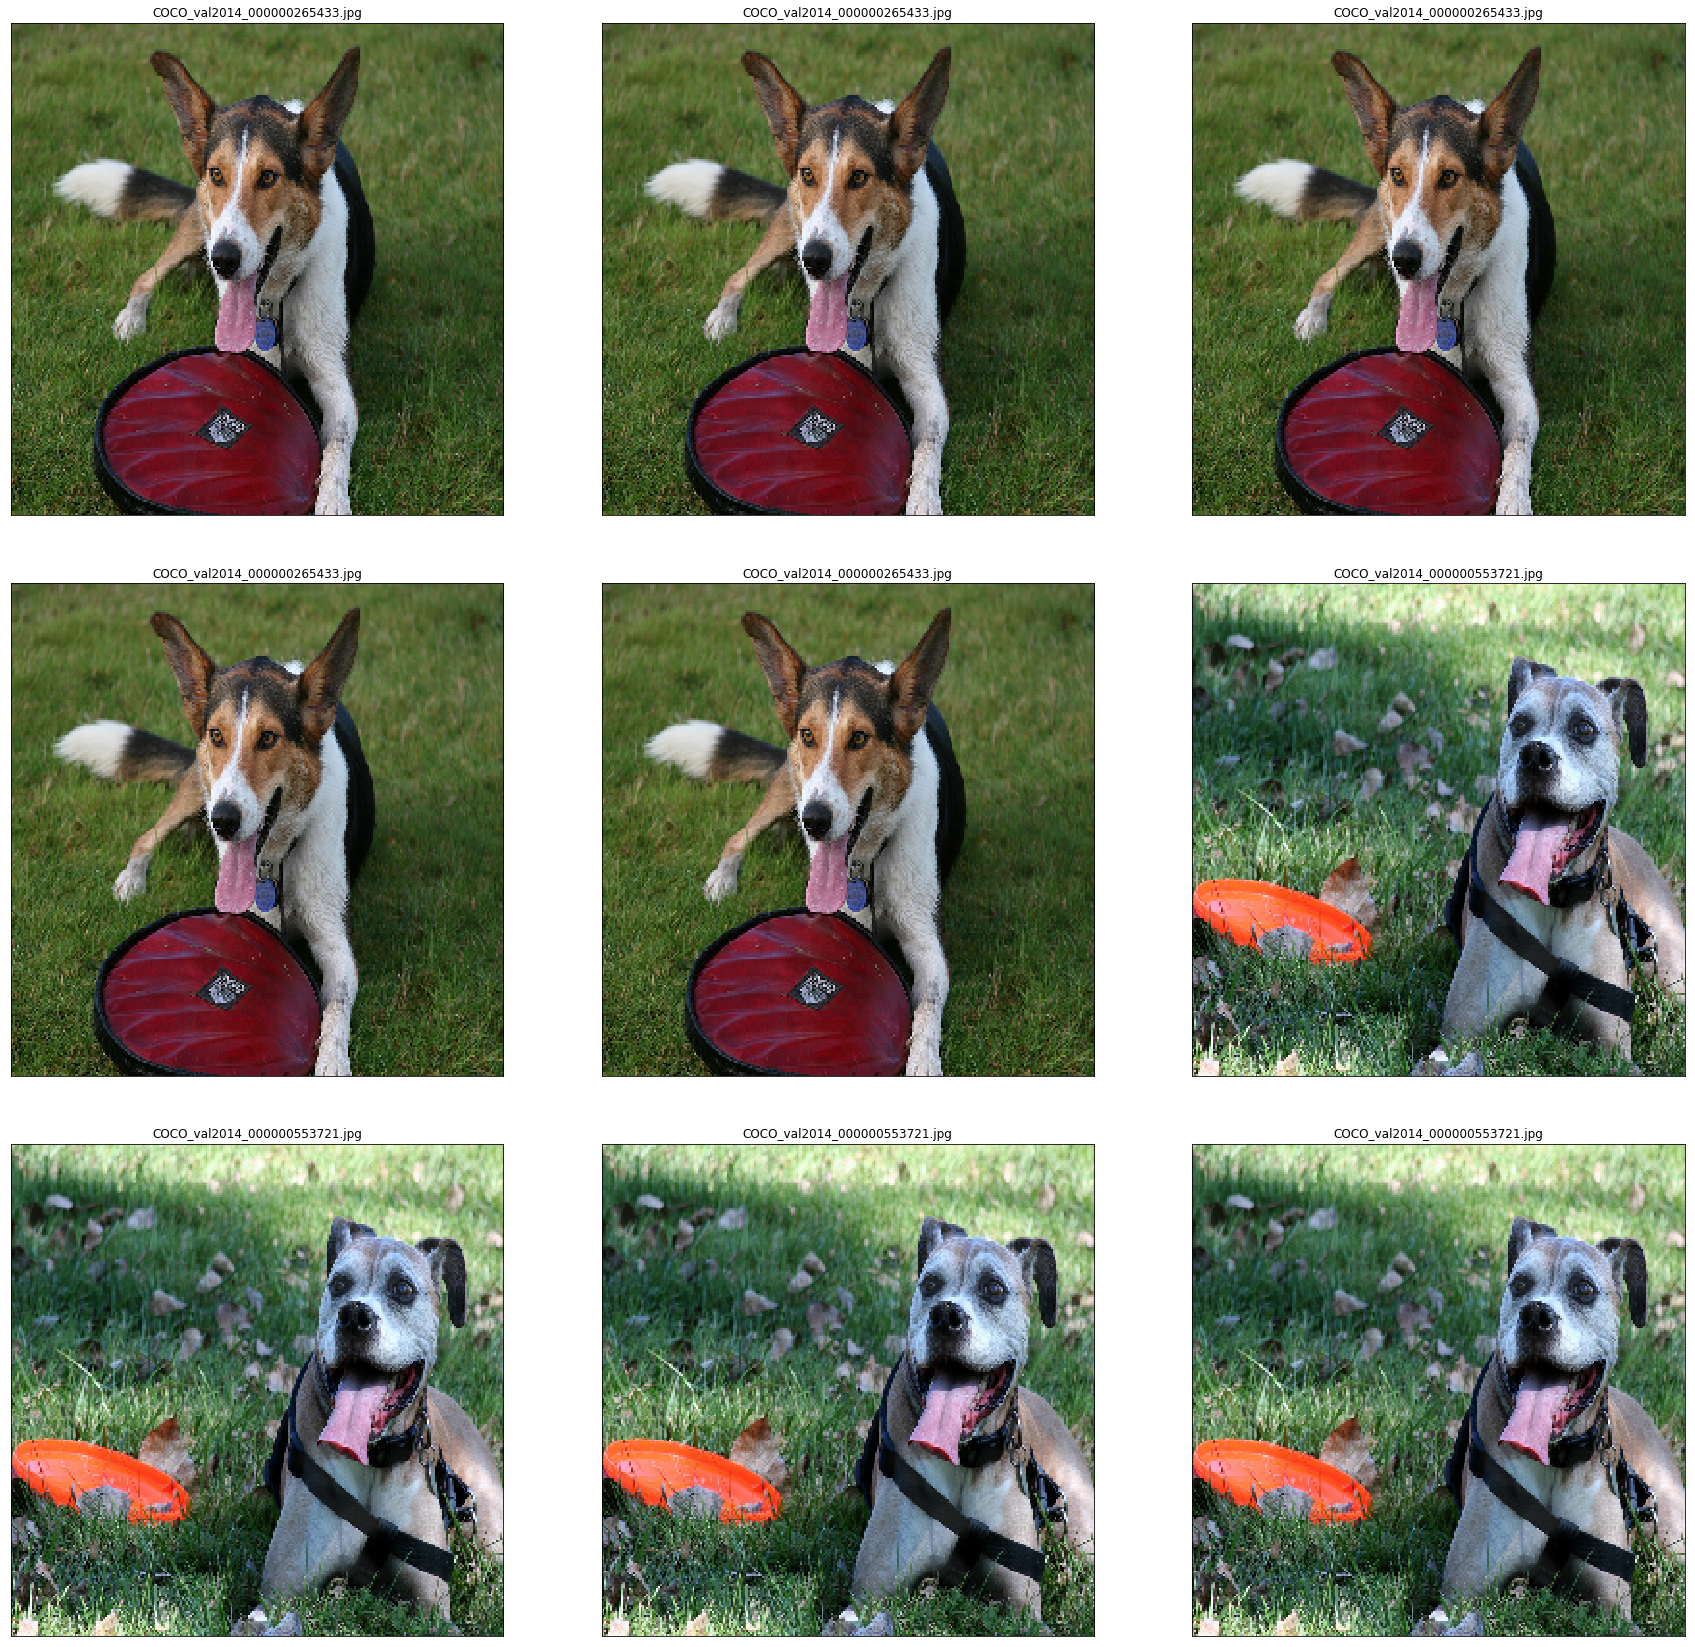

In [163]:
# encode query image to vector & perform KNN search
imgvec = model.img_enc(torch.autograd.Variable(queryimg, volatile=True))
imgvec = imgvec.data.cpu().numpy().squeeze()
distances, indices = neighbors.kneighbors([imgvec])
pylab.rcParams['figure.figsize'] = (30, 30)
plt.subplots_adjust(hspace=.1)
for i, idx in enumerate(indices[0]):
    respath = imgbasepath+imgpaths[idx]
    resimg = Image.open(respath).resize((256,256))
    sbplt = plt.subplot(3,3,1+i)
    sbplt.set_title(respath.split("/")[-1])
    sbplt.get_xaxis().set_visible(False)
    sbplt.get_yaxis().set_visible(False)
    plt.imshow(resimg)

In [158]:
len(imgpaths)

5000

In [ ]:
# encode text to vector